# 3 Build a custom dataloader

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
sys.path.insert(0, "../..")

from src.data import data_tools
from pathlib import Path
import numpy as np
# import trax.fastmath.numpy as np
# NB: you will get a cuda warning if you don't have a GPU available.

The problem with e.g. images is that the size grows pretty fast.

In [2]:
image_size = (180, 180, 3)

for i in [1, 10, 100]:
    size = (i, ) + image_size
    X = np.zeros(size)
    size_byte = X.nbytes
    print(f"Size for {i} images: {size_byte / (2**20)} MB")

Size for 1 images: 0.7415771484375 MB
Size for 10 images: 7.415771484375 MB
Size for 100 images: 74.15771484375 MB


Tensorflow has a nice [collection of datasets](https://www.tensorflow.org/datasets) for machine learning tasks. Let's download the 'flower_photos' dataset. We will use that dataset for image classification later on. 

In [3]:
import tensorflow as tf
data_dir = "../../data/raw"
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
image_folder = tf.keras.utils.get_file(
    'flower_photos', 
    origin=dataset_url, 
    untar=True,
    cache_dir=data_dir)

image_folder = Path(image_folder)

Let's  build a datagenerator from scratch; even though there are a lot of libraries (tensorflow, pytorch, trax) that provide datagenerators for images, it is a usefull practice to learn how the inside works. 

Eventually you will encounter a task were you will need to read in data from disk, and it is always usefull if you know how to adapt to a custom case. First step is to list all files in the directory:

In [4]:
paths = data_tools.walk_dir(image_folder)
file = next(paths)
file

PosixPath('/home/rgrouls/code/deep_learning/data/raw/datasets/flower_photos/tulips/4579079143_f65b39dd9f.jpg')

The stucture that is often used is to have subfolders that indicate a label. Here you see that the photo is inside the `tulips` subfolder, so the class label should be `tulips`

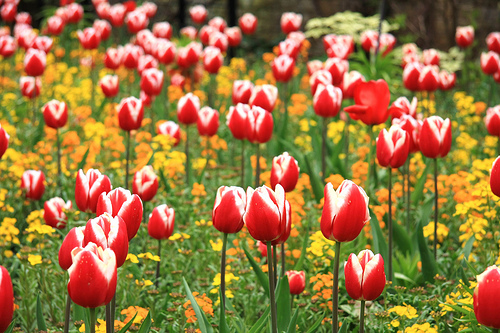

In [5]:
from PIL import Image
img = Image.open(file)
img

Study the code inside the `src.data.data_tools.py` file to see how this function works.

The `data_tools.iter_valid_paths` function pulls all files, retrieves the classnames by gathering the names of the subfolders, and returns both

In [11]:
from src.data import data_tools

formats = [".png", ".jpg"]
paths, class_names = data_tools.iter_valid_paths(
    path = image_folder, 
    formats=formats
)

In [12]:
next(paths), class_names

(PosixPath('/home/rgrouls/code/deep_learning/data/raw/datasets/flower_photos/tulips/4579079143_f65b39dd9f.jpg'),
 ['tulips', 'roses', 'dandelion', 'sunflowers', 'daisy'])

And, last, we need the `data_tools.load_image` function.

While there are multiple libraries available to load images (`pyvips`, `PIL`) the functions from `tensorflow` are the fastest for the sequence of tasks:
- load image from disk
- decode into an array of numbers
- resize the image to a fixed size
- cast to `numpy` array

In [15]:
file = next(paths)
img = data_tools.load_image(file, (180, 180), 3)
type(img), img.shape

(numpy.ndarray, (180, 180, 3))

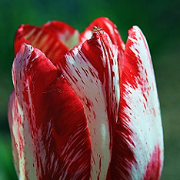

In [17]:
Image.fromarray(img.astype(np.uint8))

With this, we can construct our own data generator, using the design pattern we looked at in lesson 2.

- We gather all the paths to files
- We shuffle the index_list 
- For the range of `batchsize`, we use the `index_list[index]` design pattern to gather a random batch
- label name is extacted from the subfolder name

In [22]:
datagen = data_tools.data_generator(
    batch_size = 32, 
    path = image_folder, 
    image_size = (150, 150),
    channels = 3,
    shuffle = True
)

We can time this, and it is fast enough.

In [23]:
%timeit next(datagen)

103 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
X, y = next(datagen)
X.shape, y.shape

((32, 150, 150, 3), (32,))